In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt
import pytz

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
import bout.assembly as bt
import comparison.data_assembly as comp
import comparison.plot as complot
from core import SITE_NAMES

from cli import get_file_paths
import plot
import pipeline

In [4]:
def get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p, upb):
    points_dc = pd.DataFrame(plt_dcmetr.values, columns=['values'], index=plt_dcmetr.index)
    points_c = pd.DataFrame(plt_cmetr.values, columns=['values'], index=plt_cmetr.index)
    points_c = points_c[points_c!=0].dropna()
    points_dc = points_dc.loc[points_c.index]
    total_num_points = points_dc.shape[0]

    axis = 1
    within_bounds = ((points_dc.values<=points_c.values*(axis+(upb*p)))&(points_dc.values>=points_c.values*(axis-p)))
    num_points_in_bounds = np.sum(within_bounds.astype(int), axis=0)
    percent_points_in_bounds = num_points_in_bounds / total_num_points
    all_points_bound = p[percent_points_in_bounds==1][0]

    test_true_100_at_factor(points_dc, points_c, all_points_bound)

    return percent_points_in_bounds

def test_true_100_at_factor(points_dc, points_c, p):
    test_dc = points_dc[points_dc!=0].dropna()
    test_c = points_c.loc[test_dc.index]
    filt_dc = (test_dc.values>test_c.values*(1+p))|(test_dc.values<test_c.values*(1-p))
    assert filt_dc.all()==False

def plot_variance_of_points_log(plt_dcmetr, plt_cmetr, data_params): 
    dc_tag_split = re.findall(r"\d+", plt_dcmetr.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    dctag1 = re.search(r"\d+of\d+", plt_dcmetr.columns[0])[0]
    upper_bound_line = (1/listening_ratio)-1
    if data_params['upb']!=1:
        upb = upper_bound_line
    else:
        upb = data_params['upb']
    zero_bound_points = 1.0

    p = np.arange(0, 6, 0.01) + 1e-14
    percent_points_in_bounds = get_percent_points_in_bounds_log(plt_dcmetr, plt_cmetr, p, upb)

    p_inds = np.where(np.isclose(p, data_params['P'], atol=1e-6))[0][0]
    points_on_line = percent_points_in_bounds[p_inds]

    plt.title(f'{data_params["metric_tag"]} ({dctag1}) and cont.')
    plt.plot(p, percent_points_in_bounds)
    plt.axhline(y=points_on_line, label=f'{round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=zero_bound_points, label=f'0s captured at p={zero_bound_points}',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.axvline(x=upper_bound_line, label=f'UB captured at p={upper_bound_line}',
                linestyle='dashed', color='k', linewidth=2, alpha=0.5)
    plt.grid(which='both')
    plt.xlabel('% bounds')
    plt.xlim(-0.1, max(1, upper_bound_line)+0.2)
    plt.ylim(-0.1, 1.6)
    plt.ylabel('% of scattered points within bounds')
    plt.legend(loc=1)

def plot_all_dc_scheme_variance_of_points_log(dc_activity_arr, c_activity_arr, data_params):
    plt.figure(figsize=(5*len(data_params['percent_ons']), 5*len(data_params['cycle_lengths'])))
    plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {data_params["start"]} to {data_params["end"]}', 
                 y=1.01, fontsize=24)
    plt.rcParams.update({'font.size':12})
    for i, dc_col in enumerate(data_params["dc_tags"][1:]):
        plt.subplot(len(data_params['cycle_lengths']), len(data_params['percent_ons']), i+1)
        metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
        cycle_length = int(dc_col.split('of')[-1])
        cont_tag = f'{cycle_length}of{cycle_length}'
        cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
        metric_for_scheme = pd.DataFrame(dc_activity_arr.loc[:,metric_col_name].dropna())
        cont_column = pd.DataFrame(c_activity_arr.loc[:,cont_metric_col_name].dropna())
        metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
        plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
        plot_variance_of_points_log(plt_dcmetr, plt_cmetr, data_params)

    plt.tight_layout()
    plt.show()

In [5]:
avail = np.arange(0, 180, 2) + 2
reset_3 = avail[np.where((3*60 % avail) == 0)[0]]
reset_4 = avail[np.where((4*60 % avail) == 0)[0]]
reset_6 = avail[np.where((6*60 % avail) == 0)[0]]
reset_12 = avail[np.where((12*60 % avail) == 0)[0]]
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]

In [6]:
reset_6

array([  2,   4,   6,   8,  10,  12,  18,  20,  24,  30,  36,  40,  60,
        72,  90, 120, 180])

In [7]:
f = 10
fact_ = reset_12[np.where((reset_12%f) == 0)[0]]
fact_

array([ 10,  20,  30,  40,  60,  80,  90, 120, 180])

In [8]:
step = 1/10
step_by = np.arange(step, 1, step)
# step_by = step_by[step_by>=(1/6)]
step_by

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [9]:
cycle_lengths = fact_
percent_ons = step_by
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(cycle_lengths, percent_ons)

site_keys = ['Carp', 'Telephone']
type_keys = ['LF', 'HF']
activity_types = ['high', 'low']
data_params["dc_tags"] = dc_tags
data_params['cur_dc_tag'] = '30of30'
data_params['index_time_block'] = 5
data_params['recording_start'] = '03:00'
data_params['recording_end'] = '13:00'
dt_starts = {'Carp high':dt.datetime(2022, 7, 15, 3, 0, 0),
             'Carp low':dt.datetime(2022, 9, 15, 0, 0, 0),
           'Telephone high':dt.datetime(2022, 8, 20, 3, 0, 0),
           'Telephone low':dt.datetime(2022, 9, 17, 0, 0, 0),
             'Central':dt.datetime(2022, 7, 10, 0, 0, 0),
             'Foliage':dt.datetime(2022, 7, 10, 0, 0, 0)}
dt_ends = {'Carp high':dt.datetime(2022, 9, 15, 13, 0, 0),
           'Carp low':dt.datetime(2022, 10, 15, 0, 0, 0),
           'Telephone high':dt.datetime(2022, 8, 22, 13, 0, 0),
           'Telephone low':dt.datetime(2022, 10, 17, 16, 0, 0),
           'Central':dt.datetime(2022, 10, 30, 16, 0, 0),
           'Foliage':dt.datetime(2022, 10, 30, 16, 0, 0)}
high_activity_types = {'Carp':'LF', 'Telephone':'HF'}
data_params['P'] = 0.25
data_params['upb'] = 1

In [10]:
ai_points = {'Carp high':[], 
             'Carp low':[],
             'Telephone high':[],
             'Telephone low':[]}

In [11]:
# for site_key in site_keys:
site_key = 'Carp'
type_key = high_activity_types[site_key]
# for actvt_key in activity_types:
actvt_key = 'high'
data_params['start'] = dt_starts[f'{site_key} {actvt_key}']
data_params['end'] = dt_ends[f'{site_key} {actvt_key}']
# if (site_key=='Carp' and type_key=='LF') or (site_key=='Telephone' and type_key=='HF'):
print(site_key, type_key)
data_params["site_tag"] = site_key
data_params["site_name"] = SITE_NAMES[site_key]
data_params["type_tag"] = type_key
file_paths = get_file_paths(data_params)

Carp LF


In [12]:
def plot_indiv_dc_control_comp_over_cycle_linear_scale(single_col_dc_metr1, single_col_c_metr, data_params, hide_bounds=False, drop_zero=False):
    dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
    dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                        columns=single_col_dc_metr1.index.date, 
                        values=single_col_dc_metr1.columns[0])
    if drop_zero:
        dc_metr1 = dc_metr1.replace(0, np.NaN)
    dctag1 = re.search(r"\d+of\d+", single_col_dc_metr1.columns[0])[0]
    metrictag1 = (single_col_dc_metr1.columns[0]).split()[0]
    single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
    paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    cont_tag = f'{total}of{total}'
    plt.title(f'DC scheme compared to continuous', y=1.05)
    
    non_zero_c_metr_min = c_metr.replace(0, np.NaN).min().min()
    dc_metr_max = dc_metr1.max().max()
    c_metr_max = c_metr.max().max()
    bound_c_values = np.linspace(1e-2, 1e3, 10001)
    if not(hide_bounds):
        if data_params['metric_tag']=='activity_index':
            lower_bound = (100/(60/5))*(1/on)
            plt.axhline(y=lower_bound, linestyle='dashed', color='g', label='low: $on time^{-1}$')
        elif data_params['metric_tag']=='call_rate':
            lower_bound = (1/on)
            plt.axhline(y=lower_bound, linestyle='dashed', color='g', label='low: $on time^{-1}$')

        if data_params['metric_tag']=='bout_time_percentage':
            plt.axhline(y=100, linestyle='dashed', color='g', label='100% line')
        elif data_params['metric_tag']=='activity_index':
            plt.axhline(y=100, linestyle='dashed', color='g', label='100% line')
        plt.plot(bound_c_values, (1/listening_ratio)*bound_c_values, linestyle='dashed', color='g', label='upp: $ratio^{-1}$*c')
    upper_bound_line = (1/listening_ratio)-1
    if data_params['upb']!=1:
        upb = upper_bound_line
    else:
        upb = data_params['upb']
    plt.fill_between(bound_c_values, (1+(upb*data_params['P']))*bound_c_values, max(0, 1-data_params['P'])*bound_c_values, 
                    linestyle='dashed', color='grey', label=f'{round(100*(1+(upb*data_params["P"])))}%-{round(100*(1-data_params["P"]))}%',
                    alpha=0.6)
    
    plt.plot([0, 100*c_metr_max], [0, 100*c_metr_max], linestyle='dashed', color='k')

   
    if data_params['metric_tag']=='call_rate':
        colmap = 'Reds'
        col = 'red'
        mtag = 'CR'
    elif data_params['metric_tag']=='activity_index':
        colmap='Blues'
        col = 'blue'
        mtag = 'AI%'
    else:
        colmap='Greens'
        col = 'green'
        mtag = 'BTP'
    colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
    times = pd.date_range(data_params['start'], dt.datetime.combine(data_params['start'].date(), data_params['end'].time()), freq=f'{cycle_length}T')
    labels = pd.to_datetime(times, format='%H:%M:%S').tz_localize('UTC')
    labels = labels.tz_convert('US/Pacific').strftime('%H:%M')
    sc = plt.scatter(c_metr, dc_metr1, c=colors, cmap=colmap, edgecolors='k', s=80, alpha=1)
    cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
    cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
    plt.xlabel(f'Continuous Measurements ({mtag})')
    upper_lim = 1.6*(dc_metr_max)
    if (data_params['metric_tag'] == 'call_rate'):
        plt.xlim(-upper_lim/10, upper_lim)
        plt.ylim(-upper_lim/10, upper_lim)
        plt.legend(loc=4)
    else:
        plt.legend(loc=4)
        plt.xlim(-10, 1.6e2)
        plt.ylim(-10, 1.6e2)
    plt.ylabel(f'DC Measurements ({mtag})')
    plt.grid(which='both')

def plot_all_dc_scheme_comps_linear_scale(dc_activity_arr, c_activity_arr, data_params):
    plt.figure(figsize=(6*len(data_params['percent_ons']), 5*len(data_params['cycle_lengths'])))
    plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {data_params["start"]} to {data_params["end"]}', 
                 y=1.01, fontsize=24)
    plt.rcParams.update({'font.size':14})
    for i, dc_col in enumerate(data_params["dc_tags"][1:]):
        plt.subplot(len(data_params['cycle_lengths']), len(data_params['percent_ons']), i+1)
        metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
        cycle_length = int(dc_col.split('of')[-1])
        cont_tag = f'{cycle_length}of{cycle_length}'
        cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
        metric_for_scheme = pd.DataFrame(dc_activity_arr.loc[:,metric_col_name].dropna())
        cont_column = pd.DataFrame(c_activity_arr.loc[:,cont_metric_col_name].dropna())
        metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
        plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
        plot_indiv_dc_control_comp_over_cycle_linear_scale(plt_dcmetr, plt_cmetr, data_params)

    plt.tight_layout()
    plt.show()

In [13]:
def plot_percent_within_bounds_curve_for_metric(plt_dc_metr, plt_c_metr, data_params):
    dc_tag_split = re.findall(r"\d+", plt_dc_metr.columns[0])
    total = int(dc_tag_split[-1])
    on = int(dc_tag_split[0])
    listening_ratio = on/total
    upper_bound_line = (1/listening_ratio)-1
    if data_params['upb']!=1:
        upb = upper_bound_line
    else:
        upb = data_params['upb']
    plt.title(f'DC scheme compared to continuous')
    zero_bound_points = 1.0
    p = np.arange(0, 10, 0.01) + 1e-14
    p_inds = np.where(np.isclose(p, data_params['P'], atol=1e-6))[0][0]
    percent_points_in_bounds = get_percent_points_in_bounds_log(plt_dc_metr, plt_c_metr, p, upb)

    if data_params['metric_tag']=='call_rate':
        colmap = 'Reds'
        col = 'red'
        mtag = 'CR'
    elif data_params['metric_tag']=='activity_index':
        colmap='Blues'
        col = 'royalblue'
        mtag = 'AI'
    else:
        colmap='Greens'
        col = 'green'
        mtag = 'BTP'

    points_on_line = percent_points_in_bounds[p_inds]
    plt.plot(p, percent_points_in_bounds, label=f'({mtag}) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
                color=col, linewidth=6, alpha=0.8)

    plt.axvline(x=data_params['P'],linestyle='dashed', color='k', linewidth=2, alpha=0.5) 
    plt.xlabel('% of difference from true values')
    plt.xlim(-0.1, 1+0.2)
    plt.ylim(-0.1, 1.2)
    plt.ylabel('% of scattered points within bounds')
    plt.legend(loc=4, fontsize=16)
    plt.grid(which='both')

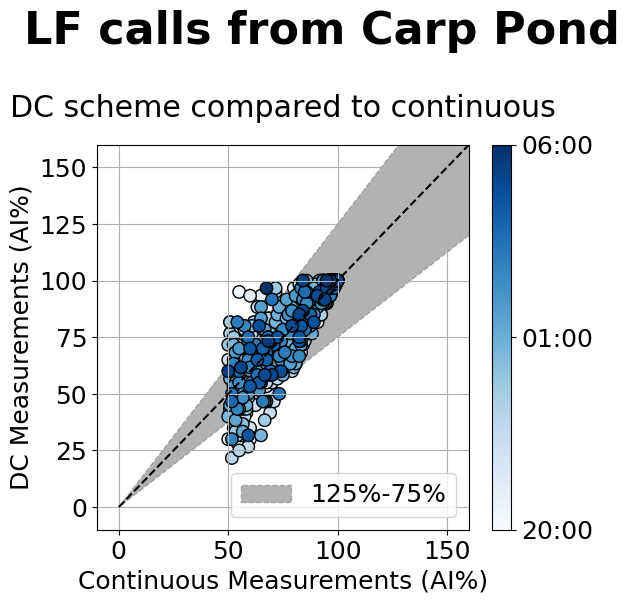

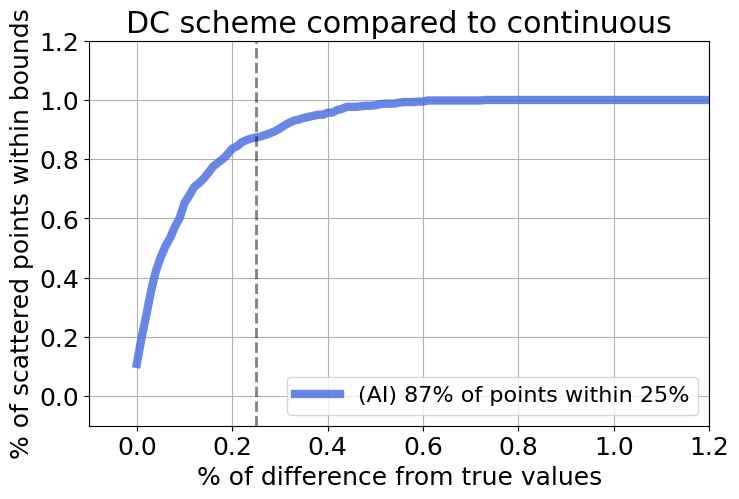

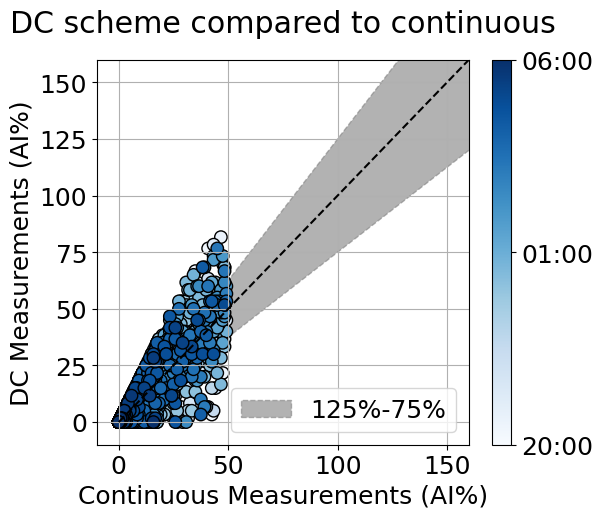

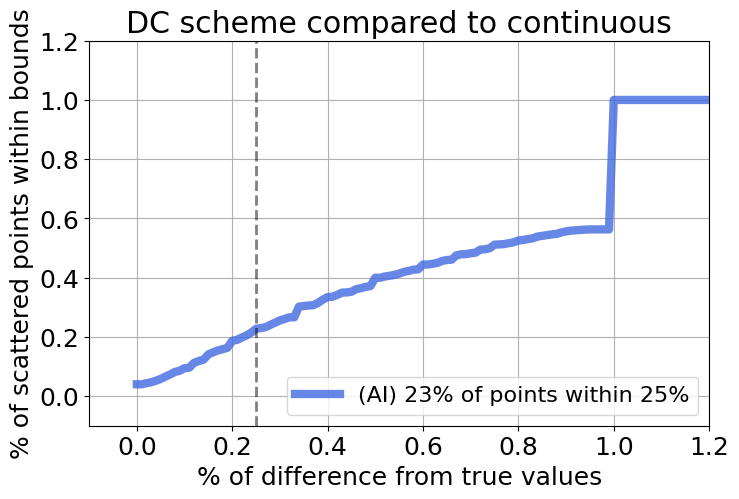

In [14]:
data_params['metric_tag'] = 'activity_index'
data_params['index_time_block_in_secs'] = '5'
actvtind_arr_dc = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_actind_TYPE_SITE_summary"]}.csv', index_col=0)
actvtind_arr_cont = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["cont_actind_TYPE_SITE_summary"]}.csv', index_col=0)
actvtind_arr_dc.index = pd.DatetimeIndex(actvtind_arr_dc.index)
actvtind_arr_cont.index = pd.DatetimeIndex(actvtind_arr_cont.index)
UBNA_tz = pytz.timezone('US/Pacific')
UTC_tz = pytz.timezone('UTC')

dt_start_UTC = UTC_tz.localize(data_params["start"])
dt_start_PST = dt_start_UTC.astimezone(UBNA_tz)
dt_end_UTC = UTC_tz.localize(data_params["end"])
dt_end_PST = dt_end_UTC.astimezone(UBNA_tz)
plot_title = f"{dt_start_PST.date()} {dt_start_PST.strftime('%H:%M')} to {dt_end_PST.date()} {(dt_end_PST).strftime('%H:%M')} PST"
dc_col = '5of10'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(actvtind_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(actvtind_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
high_cmetr = plt_cmetr[plt_cmetr>=50].dropna()
low_cmetr = plt_cmetr[plt_cmetr<50].dropna()
high_dcmetr = plt_dcmetr.loc[high_cmetr.index].copy()
low_dcmetr = plt_dcmetr.loc[low_cmetr.index].copy()

plt.figure(figsize=(6, 5))
plt.suptitle(f'{data_params["type_tag"]} calls from {data_params["site_name"]}', y=1.15, fontsize=32, fontweight='bold')
plt.rcParams.update({'font.size':18})
plot_indiv_dc_control_comp_over_cycle_linear_scale(high_dcmetr, high_cmetr, data_params, hide_bounds=True)

plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':18})
plot_percent_within_bounds_curve_for_metric(high_dcmetr, high_cmetr, data_params)
plt.show()

plt.figure(figsize=(6, 5))
# plt.suptitle(f'{plot_title}', y=1.15, fontsize=32, fontweight='bold')
plt.rcParams.update({'font.size':18})
plot_indiv_dc_control_comp_over_cycle_linear_scale(low_dcmetr, low_cmetr, data_params, hide_bounds=True)

plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':18})
plot_percent_within_bounds_curve_for_metric(low_dcmetr, low_cmetr, data_params)
plt.show()

In [15]:
plt_cmetr.shape, high_cmetr.shape, low_cmetr.shape

((3843, 1), (561, 1), (3282, 1))

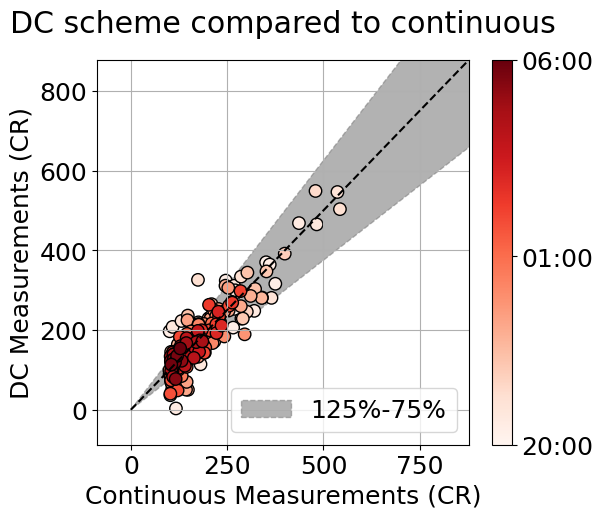

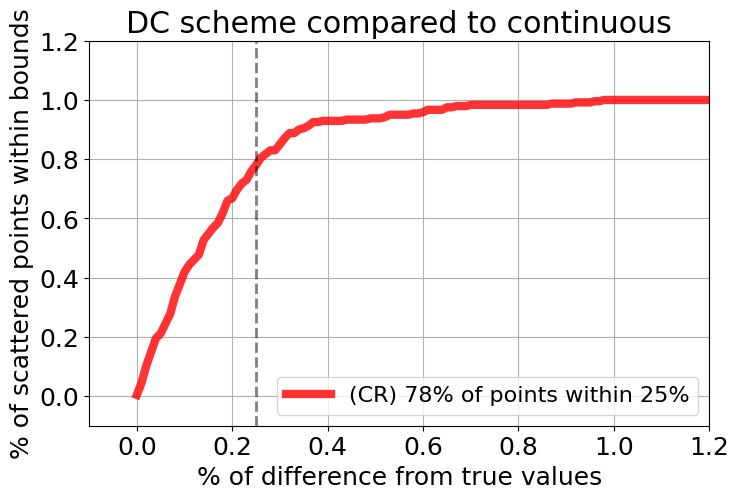

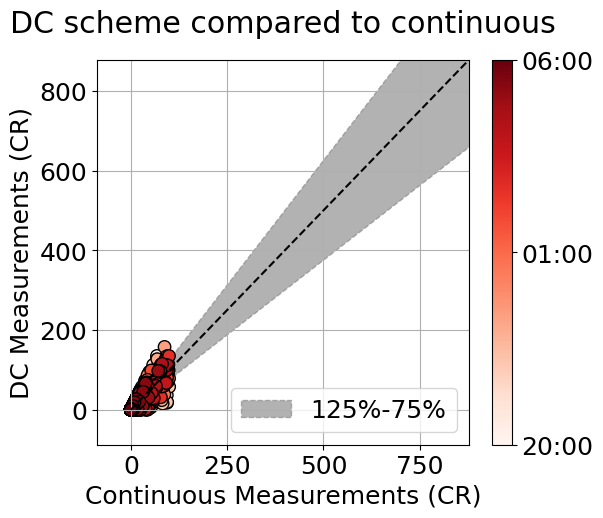

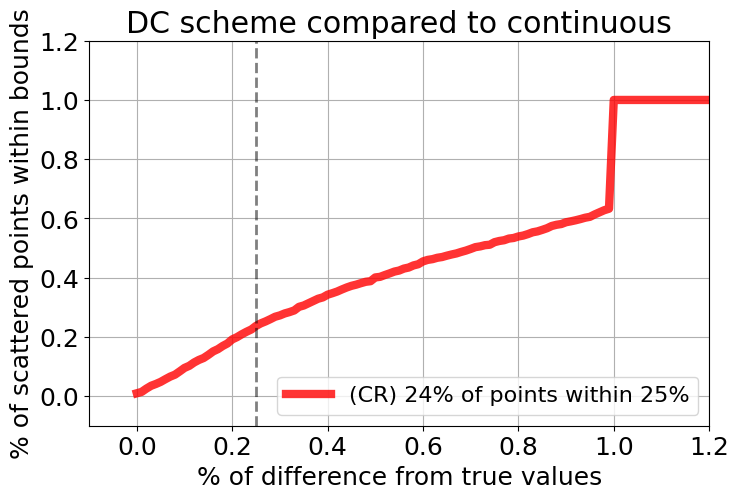

In [16]:
data_params['metric_tag'] = 'call_rate'
callrate_arr_dc = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_callrate_TYPE_SITE_summary"]}.csv', index_col=0)
callrate_arr_cont = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["cont_callrate_TYPE_SITE_summary"]}.csv', index_col=0)
callrate_arr_dc.index = pd.DatetimeIndex(callrate_arr_dc.index)
callrate_arr_cont.index = pd.DatetimeIndex(callrate_arr_cont.index)
UBNA_tz = pytz.timezone('US/Pacific')
UTC_tz = pytz.timezone('UTC')

dt_start_UTC = UTC_tz.localize(data_params["start"])
dt_start_PST = dt_start_UTC.astimezone(UBNA_tz)
dt_end_UTC = UTC_tz.localize(data_params["end"])
dt_end_PST = dt_end_UTC.astimezone(UBNA_tz)
plot_title = f"{dt_start_PST.date()} {dt_start_PST.strftime('%H:%M')} to {dt_end_PST.date()} {(dt_end_PST).strftime('%H:%M')} PST"

dc_col = '5of10'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(callrate_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(callrate_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
high_cmetr = plt_cmetr[plt_cmetr>=100].dropna()
low_cmetr = plt_cmetr[plt_cmetr<100].dropna()
high_dcmetr = plt_dcmetr.loc[high_cmetr.index].copy()
low_dcmetr = plt_dcmetr.loc[low_cmetr.index].copy()

plt.figure(figsize=(6, 5))
# plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {plot_title}', 
#                 y=1.01, fontsize=14)
plt.rcParams.update({'font.size':18})
plot_indiv_dc_control_comp_over_cycle_linear_scale(high_dcmetr, high_cmetr, data_params, hide_bounds=True)

plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':18})
plot_percent_within_bounds_curve_for_metric(high_dcmetr, high_cmetr, data_params)
plt.show()

plt.figure(figsize=(6, 5))
# plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {plot_title}', 
#                 y=1.01, fontsize=14)
plt.rcParams.update({'font.size':18})
# plot_indiv_dc_control_comp_over_cycle_linear_scale(low_dcmetr, low_cmetr, data_params, hide_bounds=True)

single_col_dc_metr1 = low_dcmetr.copy()
single_col_c_metr = low_cmetr.copy()
dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
total = int(dc_tag_split[-1])
on = int(dc_tag_split[0])
listening_ratio = on/total
single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                    columns=single_col_dc_metr1.index.date, 
                    values=single_col_dc_metr1.columns[0])

dctag1 = re.search(r"\d+of\d+", single_col_dc_metr1.columns[0])[0]
metrictag1 = (single_col_dc_metr1.columns[0]).split()[0]
single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                columns=paired_col_c_metr.index.date, 
                values=paired_col_c_metr.columns[0])
cont_tag = f'{total}of{total}'
plt.title(f'DC scheme compared to continuous', y=1.05)

non_zero_c_metr_min = c_metr.replace(0, np.NaN).min().min()
dc_metr_max = dc_metr1.max().max()
c_metr_max = c_metr.max().max()
bound_c_values = np.linspace(1e-2, 1e3, 10001)
upper_bound_line = (1/listening_ratio)-1
if data_params['upb']!=1:
    upb = upper_bound_line
else:
    upb = data_params['upb']
plt.fill_between(bound_c_values, (1+(upb*data_params['P']))*bound_c_values, max(0, 1-data_params['P'])*bound_c_values, 
                linestyle='dashed', color='grey', label=f'{round(100*(1+(upb*data_params["P"])))}%-{round(100*(1-data_params["P"]))}%',
                alpha=0.6)

plt.plot([0, 100*c_metr_max], [0, 100*c_metr_max], linestyle='dashed', color='k')


if data_params['metric_tag']=='call_rate':
    colmap = 'Reds'
    col = 'red'
    mtag = 'CR'
elif data_params['metric_tag']=='activity_index':
    colmap='Blues'
    col = 'blue'
    mtag = 'AI%'
else:
    colmap='Greens'
    col = 'green'
    mtag = 'BTP'
colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
times = pd.date_range(data_params['start'], dt.datetime.combine(data_params['start'].date(), data_params['end'].time()), freq=f'{cycle_length}T')
labels = pd.to_datetime(times, format='%H:%M:%S').tz_localize('UTC')
labels = labels.tz_convert('US/Pacific').strftime('%H:%M')
sc = plt.scatter(c_metr, dc_metr1, c=colors, cmap=colmap, edgecolors='k', s=80, alpha=1)
cbar = plt.colorbar(sc, ticks=[0, (colors.shape[0]-1)//2, colors.shape[0]-1])
cbar.ax.set_yticklabels([labels[0], labels[len(labels)//2], labels[-1]])
plt.xlabel(f'Continuous Measurements ({mtag})')
upper_lim = 1.6*(high_dcmetr.max().item())
if (data_params['metric_tag'] == 'call_rate'):
    plt.xlim(-upper_lim/10, upper_lim)
    plt.ylim(-upper_lim/10, upper_lim)
    plt.legend(loc=4)
else:
    plt.legend(loc=4)
    plt.xlim(-10, 1.6e2)
    plt.ylim(-10, 1.6e2)
plt.ylabel(f'DC Measurements ({mtag})')
plt.grid(which='both')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':18})
plot_percent_within_bounds_curve_for_metric(low_dcmetr, low_cmetr, data_params)
plt.show()

In [17]:
plt_cmetr.shape, high_cmetr.shape, low_cmetr.shape

((3843, 1), (241, 1), (3602, 1))

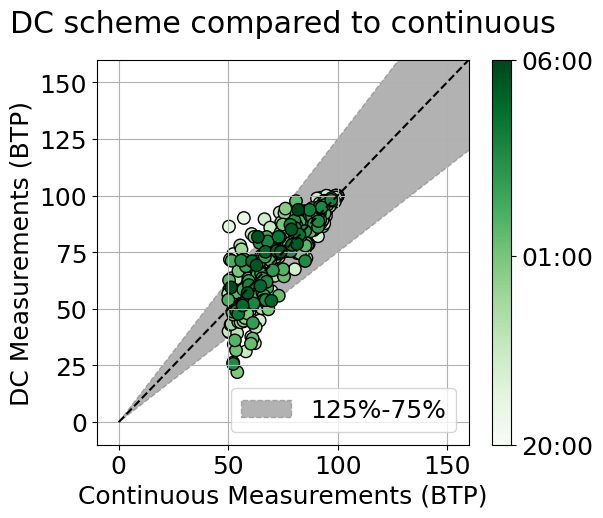

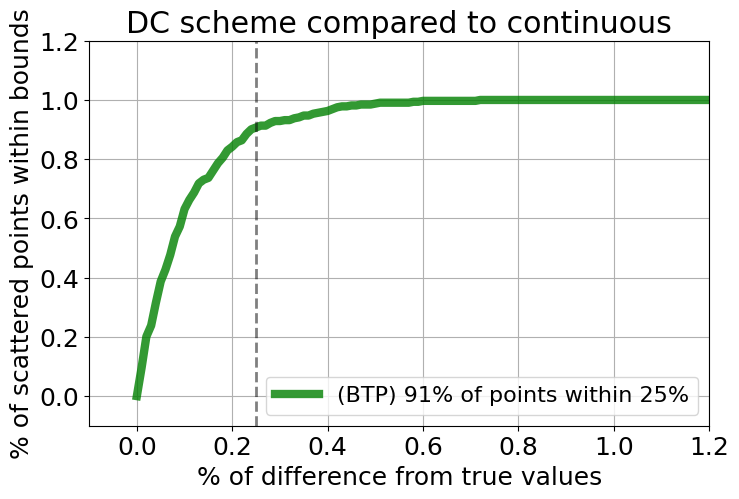

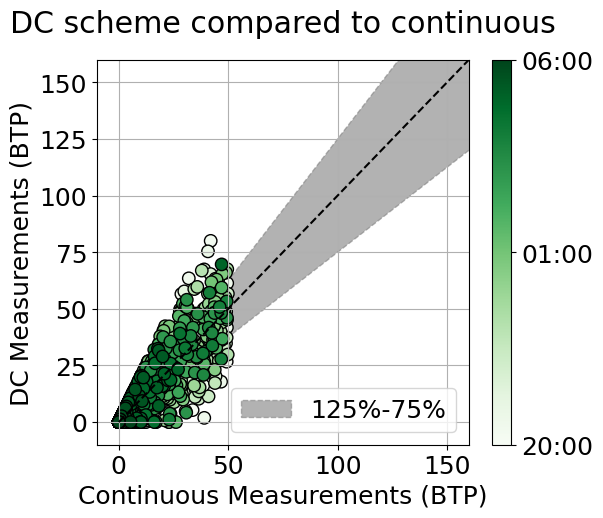

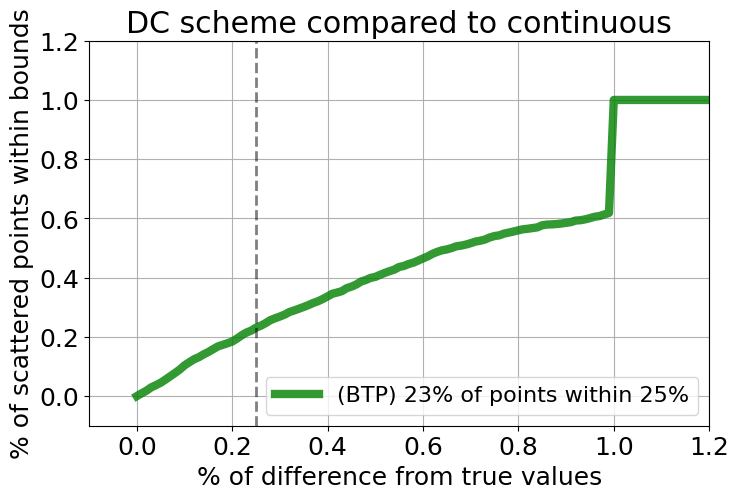

In [18]:
data_params['metric_tag'] = 'bout_time_percentage'
btp_arr_dc = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_btp_TYPE_SITE_summary"]}.csv', index_col=0)
btp_arr_cont = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["cont_btp_TYPE_SITE_summary"]}.csv', index_col=0)
btp_arr_dc.index = pd.DatetimeIndex(btp_arr_dc.index)
btp_arr_cont.index = pd.DatetimeIndex(btp_arr_cont.index)
UBNA_tz = pytz.timezone('US/Pacific')
UTC_tz = pytz.timezone('UTC')

dt_start_UTC = UTC_tz.localize(data_params["start"])
dt_start_PST = dt_start_UTC.astimezone(UBNA_tz)
dt_end_UTC = UTC_tz.localize(data_params["end"])
dt_end_PST = dt_end_UTC.astimezone(UBNA_tz)
plot_title = f"{dt_start_PST.date()} {dt_start_PST.strftime('%H:%M')} to {(dt_end_PST+pd.Timedelta(minutes=10)).strftime('%H:%M')} PST"

dc_col = '5of10'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(btp_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(btp_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
high_cmetr = plt_cmetr[plt_cmetr>=50].dropna()
low_cmetr = plt_cmetr[plt_cmetr<50].dropna()
high_dcmetr = plt_dcmetr.loc[high_cmetr.index].copy()
low_dcmetr = plt_dcmetr.loc[low_cmetr.index].copy()

plt.figure(figsize=(6, 5))
# plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {plot_title}', 
#                 y=1.01, fontsize=14)
plt.rcParams.update({'font.size':18})
plot_indiv_dc_control_comp_over_cycle_linear_scale(high_dcmetr, high_cmetr, data_params, hide_bounds=True)

plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':18})
plot_percent_within_bounds_curve_for_metric(high_dcmetr, high_cmetr, data_params)
plt.show()

plt.figure(figsize=(6, 5))
# plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {plot_title}', 
#                 y=1.01, fontsize=14)
plt.rcParams.update({'font.size':18})
plot_indiv_dc_control_comp_over_cycle_linear_scale(low_dcmetr, low_cmetr, data_params, hide_bounds=True)

plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams.update({'font.size':18})
plot_percent_within_bounds_curve_for_metric(low_dcmetr, low_cmetr, data_params)
plt.show()

In [19]:
plt_cmetr.shape, high_cmetr.shape, low_cmetr.shape

((3843, 1), (323, 1), (3520, 1))

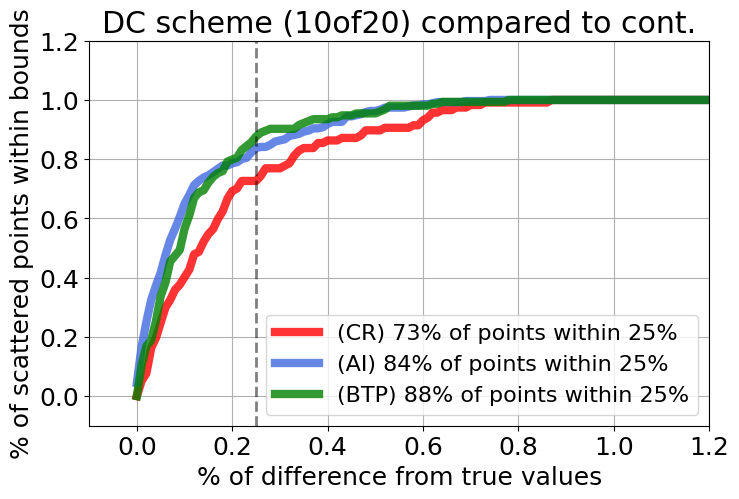

In [20]:
plt.figure(figsize=(8, 5))
# plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {data_params["start"]} to {data_params["end"]}', 
#                 y=1.01, fontsize=14)
plt.rcParams.update({'font.size':18})

dc_col = '10of20'
plt.title(f'DC scheme ({dc_col}) compared to cont.')
p = np.arange(0, 10, 0.01) + 1e-14
p_inds = np.where(np.isclose(p, data_params['P'], atol=1e-6))[0][0]

data_params['metric_tag'] = 'call_rate'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(callrate_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(callrate_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
high_cmetr = plt_cmetr[plt_cmetr>=100].dropna()
high_dcmetr = plt_dcmetr.loc[high_cmetr.index].copy()

dc_tag_split = re.findall(r"\d+", high_dcmetr.columns[0])
total = int(dc_tag_split[-1])
on = int(dc_tag_split[0])
listening_ratio = on/total
upper_bound_line = (1/listening_ratio)-1
if data_params['upb']!=1:
    upb = upper_bound_line
else:
    upb = data_params['upb']

percent_points_in_bounds = get_percent_points_in_bounds_log(high_dcmetr, high_cmetr, p, upb)
points_on_line = percent_points_in_bounds[p_inds]
plt.plot(p, percent_points_in_bounds, label=f'(CR) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
            color='red', linewidth=6, alpha=0.8)

data_params['metric_tag'] = 'activity_index'
data_params['index_time_block_in_secs'] = '5'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(actvtind_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(actvtind_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
high_cmetr = plt_cmetr[plt_cmetr>=50].dropna()
high_dcmetr = plt_dcmetr.loc[high_cmetr.index].copy()
zero_bound_points = 1.0
percent_points_in_bounds = get_percent_points_in_bounds_log(high_dcmetr, high_cmetr, p, upb)

points_on_line = percent_points_in_bounds[p_inds]
ai_points[f'{site_key} {actvt_key}']+=[points_on_line]
plt.plot(p, percent_points_in_bounds, label=f'(AI) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
            color='royalblue', linewidth=6, alpha=0.8)

data_params['metric_tag'] = 'bout_time_percentage'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(btp_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(btp_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
high_cmetr = plt_cmetr[plt_cmetr>=50].dropna()
high_dcmetr = plt_dcmetr.loc[high_cmetr.index].copy()

percent_points_in_bounds = get_percent_points_in_bounds_log(high_dcmetr, high_cmetr, p, upb)
points_on_line = percent_points_in_bounds[p_inds]
plt.plot(p, percent_points_in_bounds, label=f'(BTP) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
            color='green', linewidth=6, alpha=0.8)

# plt.axvline(x=zero_bound_points, label=f'0s captured at p={zero_bound_points}',
#             linestyle='dashed', color='k', linewidth=2, alpha=0.5) 
plt.axvline(x=data_params['P'],linestyle='dashed', color='k', linewidth=2, alpha=0.5) 
plt.xlabel('% of difference from true values')
plt.xlim(-0.1, 1+0.2)
plt.ylim(-0.1, 1.2)
plt.ylabel('% of scattered points within bounds')
plt.legend(loc=4, fontsize=16)
plt.grid(which='both')

plt.show()

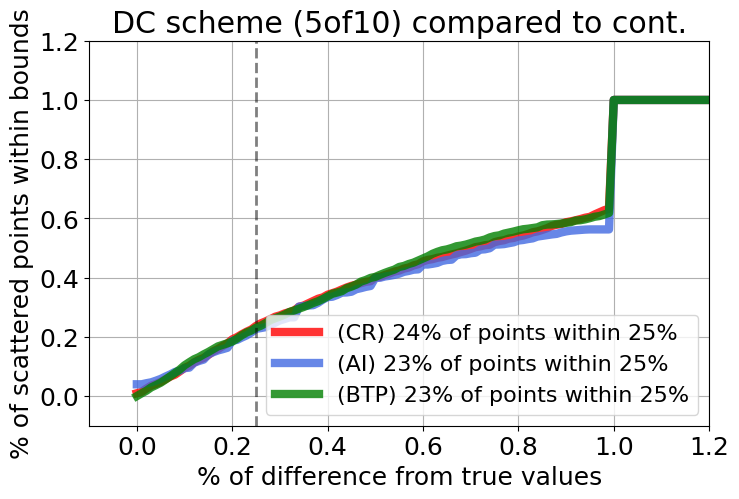

In [21]:
plt.figure(figsize=(8, 5))
# plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {data_params["start"]} to {data_params["end"]}', 
#                 y=1.01, fontsize=14)
plt.rcParams.update({'font.size':18})

dc_col = '5of10'
plt.title(f'DC scheme ({dc_col}) compared to cont.')
p = np.arange(0, 10, 0.01) + 1e-14
p_inds = np.where(np.isclose(p, data_params['P'], atol=1e-6))[0][0]

data_params['metric_tag'] = 'call_rate'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(callrate_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(callrate_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
low_cmetr = plt_cmetr[plt_cmetr<100].dropna()
low_dcmetr = plt_dcmetr.loc[low_cmetr.index].copy()

dc_tag_split = re.findall(r"\d+", high_dcmetr.columns[0])
total = int(dc_tag_split[-1])
on = int(dc_tag_split[0])
listening_ratio = on/total
upper_bound_line = (1/listening_ratio)-1
if data_params['upb']!=1:
    upb = upper_bound_line
else:
    upb = data_params['upb']

percent_points_in_bounds = get_percent_points_in_bounds_log(low_dcmetr, low_cmetr, p, upb)
points_on_line = percent_points_in_bounds[p_inds]
plt.plot(p, percent_points_in_bounds, label=f'(CR) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
            color='red', linewidth=6, alpha=0.8)

data_params['metric_tag'] = 'activity_index'
data_params['index_time_block_in_secs'] = '5'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(actvtind_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(actvtind_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
low_cmetr = plt_cmetr[plt_cmetr<50].dropna()
low_dcmetr = plt_dcmetr.loc[low_cmetr.index].copy()
zero_bound_points = 1.0
percent_points_in_bounds = get_percent_points_in_bounds_log(low_dcmetr, low_cmetr, p, upb)

points_on_line = percent_points_in_bounds[p_inds]
ai_points[f'{site_key} {actvt_key}']+=[points_on_line]
plt.plot(p, percent_points_in_bounds, label=f'(AI) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
            color='royalblue', linewidth=6, alpha=0.8)

data_params['metric_tag'] = 'bout_time_percentage'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(btp_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(btp_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
low_cmetr = plt_cmetr[plt_cmetr<50].dropna()
low_dcmetr = plt_dcmetr.loc[low_cmetr.index].copy()

percent_points_in_bounds = get_percent_points_in_bounds_log(low_dcmetr, low_cmetr, p, upb)
points_on_line = percent_points_in_bounds[p_inds]
plt.plot(p, percent_points_in_bounds, label=f'(BTP) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
            color='green', linewidth=6, alpha=0.8)

# plt.axvline(x=zero_bound_points, label=f'0s captured at p={zero_bound_points}',
#             linestyle='dashed', color='k', linewidth=2, alpha=0.5) 
plt.axvline(x=data_params['P'],linestyle='dashed', color='k', linewidth=2, alpha=0.5) 
plt.xlabel('% of difference from true values')
plt.xlim(-0.1, 1+0.2)
plt.ylim(-0.1, 1.2)
plt.ylabel('% of scattered points within bounds')
plt.legend(loc=4, fontsize=16)
plt.grid(which='both')

plt.show()

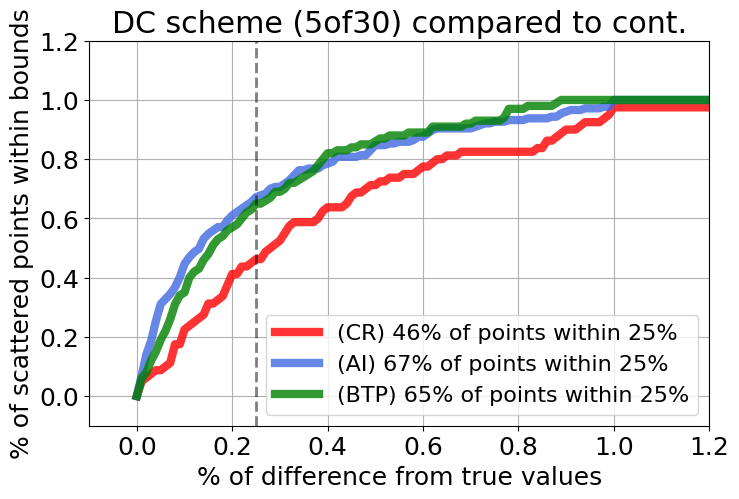

In [22]:
plt.figure(figsize=(8, 5))
# plt.suptitle(f'{data_params["site_name"]} {data_params["type_tag"]} from {data_params["start"]} to {data_params["end"]}', 
#                 y=1.01, fontsize=14)
plt.rcParams.update({'font.size':18})

dc_col = '5of30'
plt.title(f'DC scheme ({dc_col}) compared to cont.')
p = np.arange(0, 10, 0.01) + 1e-14
p_inds = np.where(np.isclose(p, data_params['P'], atol=1e-6))[0][0]

data_params['metric_tag'] = 'call_rate'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(callrate_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(callrate_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
high_cmetr = plt_cmetr[plt_cmetr>=100].dropna()
high_dcmetr = plt_dcmetr.loc[high_cmetr.index].copy()

dc_tag_split = re.findall(r"\d+", high_dcmetr.columns[0])
total = int(dc_tag_split[-1])
on = int(dc_tag_split[0])
listening_ratio = on/total
upper_bound_line = (1/listening_ratio)-1
if data_params['upb']!=1:
    upb = upper_bound_line
else:
    upb = data_params['upb']

percent_points_in_bounds = get_percent_points_in_bounds_log(high_dcmetr, high_cmetr, p, upb)
points_on_line = percent_points_in_bounds[p_inds]
plt.plot(p, percent_points_in_bounds, label=f'(CR) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
            color='red', linewidth=6, alpha=0.8)

data_params['metric_tag'] = 'activity_index'
data_params['index_time_block_in_secs'] = '5'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(actvtind_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(actvtind_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
high_cmetr = plt_cmetr[plt_cmetr>=50].dropna()
high_dcmetr = plt_dcmetr.loc[high_cmetr.index].copy()
zero_bound_points = 1.0
percent_points_in_bounds = get_percent_points_in_bounds_log(high_dcmetr, high_cmetr, p, upb)

points_on_line = percent_points_in_bounds[p_inds]
ai_points[f'{site_key} {actvt_key}']+=[points_on_line]
plt.plot(p, percent_points_in_bounds, label=f'(AI) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
            color='royalblue', linewidth=6, alpha=0.8)

data_params['metric_tag'] = 'bout_time_percentage'
metric_col_name = f'{data_params["metric_tag"]} ({dc_col})'
cycle_length = int(dc_col.split('of')[-1])
cont_tag = f'{cycle_length}of{cycle_length}'
cont_metric_col_name = f'{data_params["metric_tag"]} ({cont_tag})'
metric_for_scheme = pd.DataFrame(btp_arr_dc.loc[:,metric_col_name].dropna())
cont_column = pd.DataFrame(btp_arr_cont.loc[:,cont_metric_col_name].dropna())
metric_for_scheme_for_comparison = comp.get_associated_metric_for_cont_column(metric_for_scheme, cont_column)
plt_dcmetr, plt_cmetr = comp.select_dates_from_metrics(metric_for_scheme_for_comparison, cont_column, data_params)
high_cmetr = plt_cmetr[plt_cmetr>=50].dropna()
high_dcmetr = plt_dcmetr.loc[high_cmetr.index].copy()

percent_points_in_bounds = get_percent_points_in_bounds_log(high_dcmetr, high_cmetr, p, upb)
points_on_line = percent_points_in_bounds[p_inds]
plt.plot(p, percent_points_in_bounds, label=f'(BTP) {round(100*points_on_line)}% of points within {round(100*p[p_inds])}%',
            color='green', linewidth=6, alpha=0.8)

# plt.axvline(x=zero_bound_points, label=f'0s captured at p={zero_bound_points}',
#             linestyle='dashed', color='k', linewidth=2, alpha=0.5) 
plt.axvline(x=data_params['P'],linestyle='dashed', color='k', linewidth=2, alpha=0.5) 
plt.xlabel('% of difference from true values')
plt.xlim(-0.1, 1+0.2)
plt.ylim(-0.1, 1.2)
plt.ylabel('% of scattered points within bounds')
plt.legend(loc=4, fontsize=16)
plt.grid(which='both')

plt.show()